<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment02/PCD_Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Nama : Sapto Nugroho

##NIU : 565712

##

Implementing following program from scratch

1. Convolution Function

2. Spatial Filtering with several kernel and discuss in which image case the kernel is suitable for

3. Sharpening with blurring operation

4. Make discussion in the end of COLAB, in which case the filtering should be used instead of pixel-based method.

Create your notebook with name as "PCD_Assignment02" and upload to GitHub. You need to provide your GitHub's code link to the text editor in submission form.

## Import

In [174]:
!ls
!git clone https://github.com/sapto-nugroho/PCD.git
!ls

PCD  sample_data
fatal: destination path 'PCD' already exists and is not an empty directory.
PCD  sample_data


In [175]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io, img_as_float
import cv2
import copy

## function==============================================================================================================

### Kernel

#### Custom Kernel
$Sebarang\ matriks\ berbentuk\ berikut:$

$ K̇\begin{bmatrix}
c_{1,1} & c_{1,2} & \dots & c_{1,n} \\
c_{2,1} & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & c_{n-1,n} \\
c_{n,1} & \dots & c_{n,n-1} & c_{n,n}
\end{bmatrix}$

In [176]:
kernel_identitas = np.array([[0,0,0],[0,1,0],[0,0,0]]) #kernel identitas, konvolusi dengan citra menghasilkan citra itu sendiri

kernel_avg3x3 = np.array([[1,1,1],[1,1,1],[1,1,1]])*(1/9) #kernel averaging ukuran 3x3 atau averaging filter untuk smoothing/blurring

kernel_shiftL = np.array([[0,0,0],[1,0,0],[0,0,0]]) #kernel shift, menggeser citra
kernel_shiftR = np.array([[0,0,0],[0,0,1],[0,0,0]]) #kernel shift, menggeser citra
kernel_shiftD = np.array([[0,1,0],[0,0,0],[0,0,0]]) #kernel shift, menggeser citra
kernel_shiftU = np.array([[0,0,0],[0,0,0],[1,0,0]]) #kernel shift, menggeser citra


#### Averaging Kernel (Smoothing Kernel)

$M_{N\times N} \ adalah \ matriks \ kernel \ averaging  $

$M_{N\times N} = \frac{1}{\sum_{i=1}^{n} \sum_{j=1}^{n} c_{i,j}} \begin{bmatrix}
c_{1,1} & c_{1,2} & \dots & c_{1,n} \\
c_{2,1} & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & c_{n-1,n} \\
c_{n,1} & \dots & c_{n,n-1} & c_{n,n}
\end{bmatrix};\ c_{i,j}=1,\ ∀i,j \in N=\{1,2,3,...,n\}$


In [177]:
#membuat averaging kernel (smoothing kernel) ukuran nxn
def avg_kernel(size):
  kernel = np.ones((size, size), dtype=float) / (size * size)
  # kernel = np.ones((size, size), dtype=int) / (size * size)
  return kernel

#### Gaussian Kernel

$Matriks\ kernel\ berisi\ nilai\ yang\ terdistribusi\ secara\ normal \\
 dengan\ pusat\ distribusi\ pada\ elemen\ indeks\ (0,0)   $

$ K̇\begin{bmatrix}
e^{-\frac{(-n/2)^2+(n/2)^2}{2\sigma^2}} &  & \dots & e^{-\frac{0^2+(n/2)^2}{2\sigma^2}} & \dots & & e^{-\frac{(n/2)^2+(n/2)^2}{2\sigma^2}} \\
\vdots &  & \ddots & \vdots & .^{.^{.}} & & \vdots  \\
 &  & e^{-\frac{(-1)^2+1^2}{2\sigma^2}} & e^{-\frac{0^2+1^2}{2\sigma^2}} & e^{-\frac{1^2+1^2}{2\sigma^2}} & & \vdots  \\
e^{-\frac{(-n/2)^2+0^2}{2\sigma^2}} & \dots & e^{-\frac{(-1)^2+0^2}{2\sigma^2}} & e^{-\frac{0^2+0^2}{2\sigma^2}} & e^{-\frac{1^2+0^2}{2\sigma^2}} & \dots & e^{-\frac{(n/2)^2+0^2}{2\sigma^2}} \\
 & & e^{-\frac{(-1)^2+(-1)^2}{2\sigma^2}} & e^{-\frac{0^2+(-1)^2}{2\sigma^2}} & e^{-\frac{1^2+(-1)^2}{2\sigma^2}} &  & \vdots \\
\vdots & &.^{.^{.}} & \vdots & \ddots &  & \vdots \\
e^{-\frac{(-n/2)^2+(-n/2)^2}{2\sigma^2}} &  & \dots & e^{-\frac{0^2+(-n/2)^2}{2\sigma^2}} & \dots &  & e^{-\frac{(n/2)^2+(-n/2)^2}{2\sigma^2}}
\end{bmatrix}$

In [178]:
def gaussian_kernel(size, sigma, muu):
  # X, Y  grid f kernel size
  X, Y = np.meshgrid(np.linspace(-1, 1, size),
                      np.linspace(-1, 1, size))
  jarakXY = np.sqrt((X**2) + (Y**2))

  K = 1
  gauss = np.exp(-((jarakXY - muu)**2 / (2.0 * sigma**2)))*K

  normal_constant = 1/(np.sum(gauss))
  # print(np.sum(gauss))
  # print(gauss)

  for i in range(gauss.shape[0]):
    for j in range(gauss.shape[1]):
      # print(gauss[i,j],np.sum(gauss))
      gauss[i][j] = gauss[i][j]*normal_constant

  return gauss
  # return gauss, normal_constant

# gaussian = gaussian_kernel(3,1,0)
# print(gaussian[0])
# print(gaussian[0]*gaussian[1])

#### Sharpening Kernel (Sharpening with blurring operation)

$\begin{align*}
F + α(F-F*H) &= F*I + α(F*I - F*H) \\
             &= F + αF(I - H) \\
             &= F*( I + α(I - H)) \\
             &= F*( I + αI - αH) \\
             &= F*((1+\alpha)I - \alpha H) \\
             &= F*H_{baru}
\end{align*}$

$keterangan:$

$\begin{align*}
  F &= matriks\, citra\, ; \\  
  α &=skalar\, ; \\
  I_{n\times n} &= a_{ij} \begin{cases} \mbox{1,} & \mbox{jika }\, i=j=⌈n/2⌉ \\ \mbox{0,} & \mbox{lainnya } \end{cases}\, ; \\  
  H &= matriks\, kernel\, blurring\, ; \\
  H_{baru} &= matriks\, kernel\, sharpening.
\end{align*}$


In [179]:
def sharpening(alpha,kernel):

  size = kernel.shape[0]
  H = kernel
  I = np.zeros(shape=(size,size),dtype=float)
  I[size//2][size//2] = 1

  # sharperning_kernel = I-H
  sharperning_kernel = (1+alpha)*I - (alpha*H)
  # print(sharperning_kernel)

  return sharperning_kernel

### fungsi konvolusi

In [180]:
def konvolusi(img,kernel):

  ksize = kernel.shape[0]
  pad = ksize // 2
  kernel = np.flipud(np.fliplr(kernel))

  output = np.zeros_like(img, dtype=float)
  # output = np.zeros_like(img, dtype=int)
  # output = np.zeros_like(img)

  for c in range(3):
      padded = np.pad(img[:,:,c], pad, mode='constant')
      for i in range(img.shape[0]):      # baris
          for j in range(img.shape[1]):  # kolom
              region = padded[i:i+ksize, j:j+ksize]
              val = float(np.sum(region * kernel))
              # val = int(np.sum(region * kernel))
              # val = np.sum(region * kernel)
              output[i, j, c] = val

  if np.min(output)<0:
    output = np.clip(output,0,1)

  # return output.astype(np.uint8)
  return output

##main=================================================================================================================

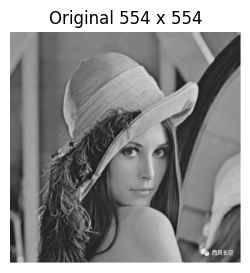

In [181]:
# img_path = '/content/PCD/PCD_Assignment02/images/4x4colour.jpg'
# img_path = '/content/PCD/PCD_Assignment02/images/8x8colour.jpg'
img_path = '/content/PCD/PCD_Assignment02/images/woman01.png'
# img_path = '/content/PCD/PCD_Assignment02/images/pattern.png'

img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = img_as_float(img)

# print(img.shape)
# print(img)

plt.figure(figsize=(10,3))
plt.imshow(img)
plt.title(f"Original {img.shape[0]} x {img.shape[1]}")
plt.axis("off")

plt.show()

In [182]:
out1 = konvolusi(img, kernel_identitas)
out2 = konvolusi(img, kernel_avg3x3)
out3 = konvolusi(img, kernel_shiftL)
out4 = konvolusi(img, avg_kernel(5))
out5 = konvolusi(img, gaussian_kernel(11,1,0))
out6 = konvolusi(img, sharpening(1,avg_kernel(5)))

# print(output)

#Plotting
# plt.figure(figsize=(10,5))

# plt.subplot(1,2,1)
# plt.imshow(img)
# plt.title("Original")
# plt.axis("off")

# plt.subplot(1,2,2)
# plt.imshow(output)
# plt.title("Processed")
# plt.axis("off")

# plt.show()

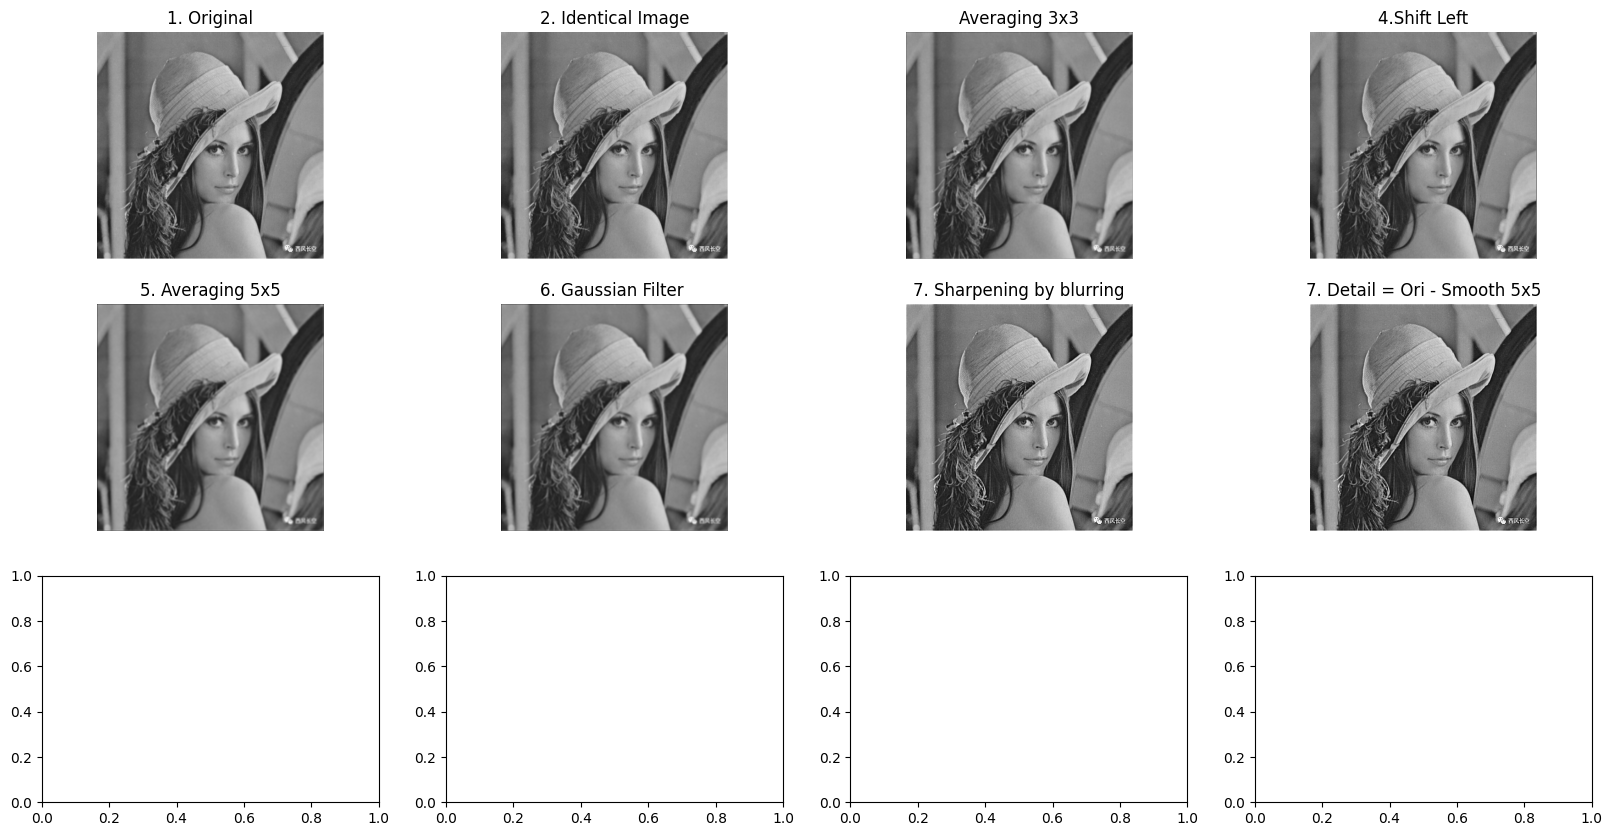

In [187]:
fig, ax = plt.subplots(3,4, figsize=(20,10))
ax[0,0].imshow(img, cmap='gray'); ax[0,0].set_title("1. Original"); ax[0,0].axis("off")
ax[0,1].imshow(out1, cmap='gray'); ax[0,1].set_title("2. Identical Image"); ax[0,1].axis("off")
ax[0,2].imshow(out2, cmap='gray'); ax[0,2].set_title("Averaging 3x3"); ax[0,2].axis("off")
ax[0,3].imshow(out3, cmap='gray'); ax[0,3].set_title("4.Shift Left"); ax[0,3].axis("off")
ax[1,0].imshow(out4, cmap='gray'); ax[1,0].set_title("5. Averaging 5x5"); ax[1,0].axis("off")
ax[1,1].imshow(out5, cmap='gray'); ax[1,1].set_title("6. Gaussian Filter "); ax[1,1].axis("off")
ax[1,2].imshow(out6, cmap='gray'); ax[1,2].set_title("7. Sharpening by blurring"); ax[1,2].axis("off")
ax[1,3].imshow(out6, cmap='gray'); ax[1,3].set_title("7. Detail = Ori - Smooth 5x5"); ax[1,3].axis("off")

# ax[2,0].imshow(image+detail_img, cmap='gray'); ax[2,0].set_title("8. Ori + Detail"); ax[2,0].axis("off")
# ax[2,1].imshow(high_pass_img, cmap='gray'); ax[2,1].set_title("9. High Pass"); ax[2,1].axis("off")
# ax[2,2].imshow(low_pass_img, cmap='gray'); ax[2,2].set_title("10. Low Pass"); ax[2,2].axis("off")
# ax[2,3].imshow(laplacian_img, cmap='gray'); ax[2,3].set_title("11. Laplacian"); ax[2,3].axis("off")
plt.show()

#JUNK

[[[0.3945098  0.3945098  0.3945098 ]
  [0.32141176 0.32141176 0.32141176]
  [0.24784314 0.24784314 0.24784314]
  ...
  [0.16878431 0.16878431 0.16878431]
  [0.15090196 0.15090196 0.15090196]
  [0.75905882 0.75905882 0.75905882]]

 [[0.3212549  0.3212549  0.3212549 ]
  [0.224      0.224      0.224     ]
  [0.12203922 0.12203922 0.12203922]
  ...
  [0.03043137 0.03043137 0.03043137]
  [0.02588235 0.02588235 0.02588235]
  [0.67827451 0.67827451 0.67827451]]

 [[0.24360784 0.24360784 0.24360784]
  [0.12235294 0.12235294 0.12235294]
  [0.00407843 0.00407843 0.00407843]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.59827451 0.59827451 0.59827451]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.59278431 0.59278431 0.59278431]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


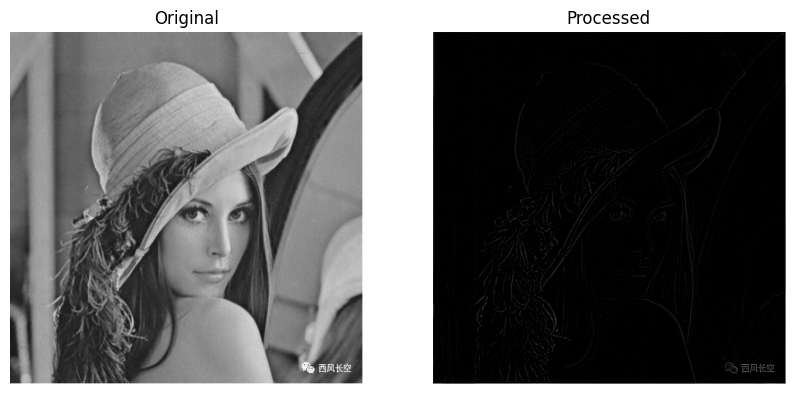

In [146]:
output1 = img - output

output1 = np.clip(output1,0,1)
# output1 = cv2.normalize(output1, None, 0, 1, cv2.NORM_MINMAX)

print(output1)

#Plotting
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img,cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(output1 ,cmap='gray')
plt.title("Processed")
plt.axis("off")

plt.show()

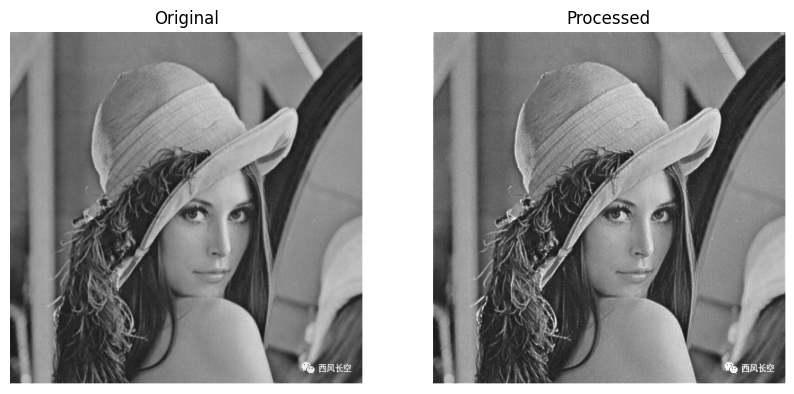

In [147]:
output2 = img + output1

output2 = np.clip(output2,0,1)
# output2 = cv2.normalize(output2, None, 0, 1, cv2.NORM_MINMAX)

#Plotting
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img,cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(output2,cmap='gray')
plt.title("Processed")
plt.axis("off")

plt.show()

In [112]:
def konvolusi(img,kernel):

  ksize = kernel.shape[0]
  pad = ksize // 2
  kernel = np.flipud(np.fliplr(kernel))

  # padding
  padded = np.pad(img, pad, mode='constant')

  # hasil konvolusi
  output = np.zeros_like(img)

  for i in range(img.shape[0]):
      for j in range(img.shape[1]):
          region = padded[i:i+ksize, j:j+ksize]
          output[i, j] = np.sum(region * kernel)

  return output

(554, 554)
[[0.61568627 0.61568627 0.61568627 ... 0.56078431 0.46666667 1.        ]
 [0.61568627 0.61568627 0.61176471 ... 0.55294118 0.44705882 1.        ]
 [0.61176471 0.61176471 0.61568627 ... 0.54901961 0.44705882 1.        ]
 ...
 [0.13333333 0.1372549  0.17254902 ... 0.40392157 0.40784314 1.        ]
 [0.1372549  0.14117647 0.17647059 ... 0.41568627 0.42745098 1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


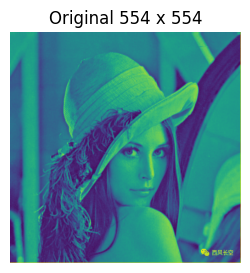

In [130]:
# img_path = '/content/PCD/PCD_Assignment02/images/4x4colour.jpg'
# img_path = '/content/PCD/PCD_Assignment02/images/8x8colour.jpg'
img_path = '/content/PCD/PCD_Assignment02/images/woman01.png'
# img_path = '/content/PCD/PCD_Assignment02/images/woman01.jpg'
# img_path = '/content/PCD/PCD_Assignment02/images/pattern.png'


img = io.imread(img_path)
img = color.rgb2gray(img)
img = img_as_float(img)

print(img.shape)
print(img)

plt.figure(figsize=(10,3))
plt.imshow(img)
plt.title(f"Original {img.shape[0]} x {img.shape[1]}")
plt.axis("off")

plt.show()

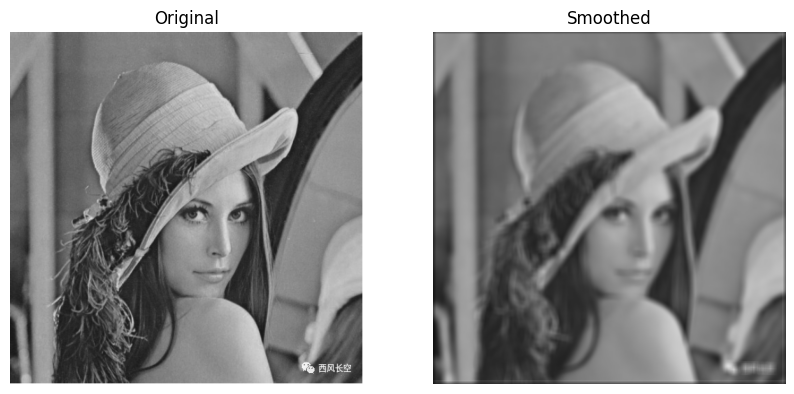

In [ ]:

def mean_smoothing(img, ksize):

  #kernel mean (ksize x ksize)
  kernel = np.ones((ksize, ksize), dtype=float) / (ksize * ksize)
  # kernel = np.ones((ksize, ksize), dtype=int) / (ksize * ksize)

  pad = ksize // 2
  output = np.zeros_like(img, dtype=float)
  # output = np.zeros_like(img, dtype=int)

  # Process tiap channel(R, G, B)
  for c in range(3):
      padded = np.pad(img[:,:,c], pad, mode='constant')
      for i in range(img.shape[0]):      # baris
          for j in range(img.shape[1]):  # kolom
              region = padded[i:i+ksize, j:j+ksize]
              value = float(np.sum(region * kernel))
              output[i, j, c] = value

  return output.astype(np.uint8)


img = cv2.imread(img_path)
# print(img.shape)
# print(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB
# print(img.shape)
# print(img)

img_smooth = mean_smoothing(img, 11)

#Plotting
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_smooth)
plt.title("Smoothed")
plt.axis("off")

plt.show()

In [ ]:
def func_convolution(img_,kernel):
  if img_copy.dtype != np.uint8:
    img_ = img_*255
    img_ = img_.astype(np.uint8)

  img_ = img_.astype(int)

  bgr = []
  if img_.shape[2] == 4:
    b,g,r,a = cv2.split(img_)
    bgr.append(b)
    bgr.append(g)
    bgr.append(r)
    bgr.append(a)
  else:
    b,g,r = cv2.split(img_)
    bgr.append(b)
    bgr.append(g)
    bgr.append(r)

  bgr_pad = []
  for i in range(3):
    # bgr_pad = np.pad(b, pad_width=((1, 1), (1, 1)), mode='constant', constant_values=0)
    bgr_pad.append(np.pad(bgr[i], pad_width=2, mode='constant', constant_values=0))
    # print(bgr_pad)

  # img_new = np.zeros((3,b.shape[0],b.shape[1])).astype(np.uint8)
  img_new = np.zeros((3,b.shape[0],b.shape[1])).astype(int)
  # print(img_new.shape)

  for h in range(3):
    for i in range(b.shape[0]):
      for j in range(b.shape[1]):
        img_new[h][i][j] = (kernel1[0][0]*bgr_pad[h][i][j]+kernel1[0][1]*bgr_pad[h][i][j+1]+kernel1[0][2]*bgr_pad[h][i][j+2])+(kernel1[1][0]*bgr_pad[h][i+1][j]+kernel1[1][1]*bgr_pad[h][i+1][j+1]+kernel1[1][2]*bgr_pad[h][i+1][j+2])+(kernel1[2][0]*bgr_pad[h][i+2][j]+kernel1[2][1]*bgr_pad[h][i+2][j+1]+kernel1[2][2]*bgr_pad[h][i+2][j+2])

  img_co = cv2.merge([img_new[0],img_new[1],img_new[2]])
  # img_co = cv2.merge([img_new[2],img_new[1],img_new[0]])
  img_co = img_co.astype(np.uint8)

  # plt.figure(figsize=(10, 10))
  plt.imshow(img_co)
  plt.show()

  return img_co

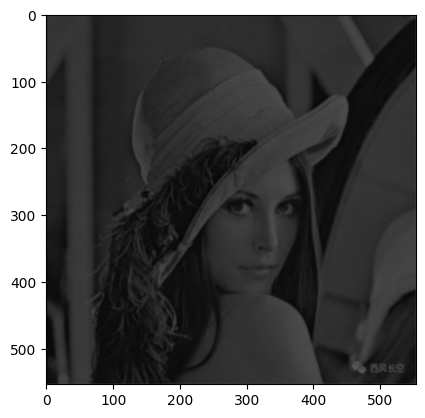

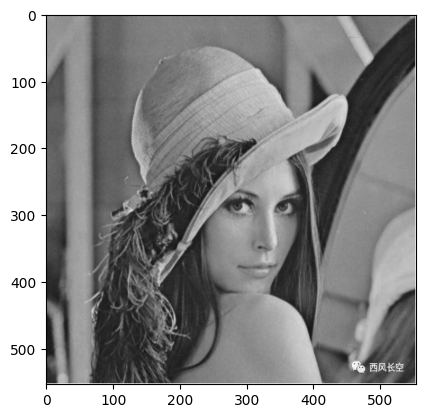

In [ ]:
# kernel1 = np.array([[0,0,0],[0,1,0],[0,0,0]])
# kernel1 = np.array([[1,1,1],[1,1,1],[1,1,1]])*(1/9)
# kernel1 = np.array([[1,2,1],[2,4,2],[1,2,1]])*(1/16)
kernel1 = np.array([[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])*(1/25)
# kernel1 = np.array([[1,2,3,2,1],[1,2,3,2,1],[1,2,3,2,1],[1,2,3,2,1],[1,2,3,2,1]])*(1/25)


output = func_convolution(img_copy,kernel1)
# plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [ ]:
import cv2
import numpy as np

def smoothing(img, ksize=11):
    # Create averaging kernel (ksize x ksize)
    kernel = np.ones((ksize, ksize), dtype=float) / (ksize * ksize)

    # Amount of padding
    pad = ksize // 2
    padded = np.pad(img, pad, mode='edge')

    # Output image
    output = np.zeros_like(img, dtype=float)

    # Manual convolution
    for i in range(img.shape[0]):      # rows
        for j in range(img.shape[1]):  # cols
            region = padded[i:i+ksize, j:j+ksize]
            value = float(np.sum(region * kernel))   # ensure scalar, not array
            output[i, j] = value

    return output.astype(np.uint8)

# === Example usage ===
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_smooth = smoothing(img, ksize=21)


# Show with matplotlib
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_smooth, cmap="gray")
plt.title("Smoothed (11x11)")
plt.axis("off")

plt.show()

In [ ]:
# x = np.array([[1,2,3],[4,5,6],[7,8,9]])
# print(x)
# padded = np.pad(x, 2, mode='constant')
# print(padded)

img = cv2.imread(img_path)   # read BGR
print(img)
print(img[:,:,1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB
# print(img[0][0])

[[[ 41   0   0]
  [130  86  79]
  [156 209 252]
  [  0   0  36]]

 [[ 72  28  21]
  [240 196 189]
  [ 93 146 189]
  [ 33  86 129]]

 [[114 221 255]
  [  0  84 118]
  [  5   0  25]
  [155 138 175]]

 [[ 49 156 190]
  [117 224 255]
  [ 87  70 107]
  [209 192 229]]]
[[  0  86 209   0]
 [ 28 196 146  86]
 [221  84   0 138]
 [156 224  70 192]]
